In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse as ph
from scipy import stats
import swifter

In [6]:
#функция для хэширования, необязательно, сделал через clickhouse

def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.mb5(test_id.encode('ancii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [7]:
#коннектимся к dwh, данные изменены

connection = {
    'host': 'https://clickhouse.internal.company.com',
    'user': 'analyst_user',
    'password': 'secure_password_123',
    'database': 'analytics_db'
}

In [8]:
# Хэшируем с солью в кликхаус

q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group
     , uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-14' and '2025-02-20'
group by group
"""

df = ph.read_clickhouse(q, connection=connection)
df.head()

,group,uniqExact(user_id)
0,0,8452
1,1,8326
2,2,8395
3,3,8492
4,4,8332


In [9]:
q = """
SELECT exp_group
     , user_id
     , sum(action = 'like') as likes
     , sum(action = 'view') as views
     , likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-14' and '2025-02-20'
    AND exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


In [10]:
sample_size = 500

sample_users_2 = np.random.choice(df[df.exp_group == 2].user_id.unique(), size=sample_size,
                                  replace=False)

sample_users_3 = np.random.choice(df[df.exp_group == 3].user_id.unique(), size=sample_size,
                                  replace=False)

df_sample_2 = df[df.user_id.isin(sample_users_2)]
df_sample_3 = df[df.user_id.isin(sample_users_3)]

ab_1 = stats.ttest_ind(df_sample_2.ctr, df_sample_3.ctr, equal_var=False)

if ab_1[1] >= 0.05: print('Распределения одинаковы, P-value =', ab_1[1])
else: print('Различия статистически значимы, P-value =', ab_1[1])

Распределения одинаковы, P-value = 0.6493802563197136


In [11]:
ab_1_test = 0

for i in range(10000):
    ab_1_test += df_sample_2.ctr.sample().values[0] > df_sample_3.ctr.sample().values[0]
    
print('В', ab_1_test / 100, '% случаев A > B. Должно получиться около 50%')

В 49.07 % случаев A > B. Должно получиться около 50%


In [17]:
data_2 = []
data_3 = []

for i in range(10000):
    data_2.append(df_sample_2.ctr.sample().values[0])
    data_3.append(df_sample_3.ctr.sample().values[0])
    
data_2 = pd.DataFrame(data_2).rename(columns={0: 'ctr'})
data_3 = pd.DataFrame(data_3).rename(columns={0: 'ctr'})

<AxesSubplot:xlabel='ctr', ylabel='Count'>

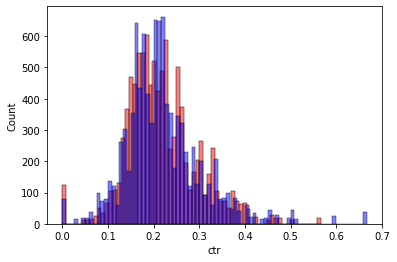

In [18]:
groups = sns.histplot(data = data_2,
x='ctr',
color = ['r'],
alpha=0.5,
kde=False)

sns.histplot(data = data_3,
x='ctr',
color = ['b'],
alpha=0.5,
kde=False)

In [19]:
mean_share = ((data_2 < 0.05).mean() + (data_3 < 0.05).mean()) / 2

In [20]:
mean_share

ctr    0.012
dtype: float64

Распределение получившихся p-value является примерно 
равномерным
. Доля p-value ниже порога значимости составляет около 
0.0136
. Это 
примерно столько, сколько
 мы ожидаем. Значит, система сплитования 
работает корректно
.

## Анализ результатов эксперимента

<AxesSubplot:xlabel='ctr', ylabel='Count'>

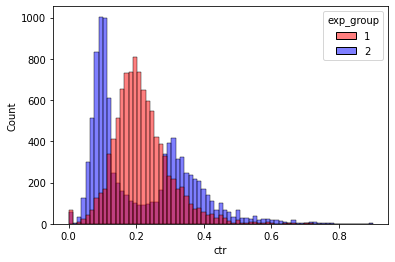

In [14]:
q = """
SELECT exp_group
     , user_id
     , sum(action = 'like') as likes
     , sum(action = 'view') as views
     , likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-21' and '2025-02-27'
    AND exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df2 = ph.read_clickhouse(q, connection=connection)

sns.histplot(data = df2,
x='ctr',
hue = 'exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

### t-test может быть неточным из-за формы распределения, распределение бимодально "с двумя горбами", поэтому результат сложно интерпретировать

In [15]:
ab_2 = stats.ttest_ind(df2[df2.exp_group == 1].ctr, df2[df2.exp_group == 2].ctr)

if ab_2[1] >= 0.05: print('Распределения одинаковы, P-value =', ab_2[1])
else: print('Различия статистически значимы, P-value =', ab_2[1])

Распределения одинаковы, P-value = 0.6843098628062774


### Тест Манна-Уитни показывает статистическую значимость, выборки стохастически неравны, даже на глаз явная ассиметрия

In [16]:
ab_2_mw = stats.mannwhitneyu(df2[df2.exp_group == 1].ctr, df2[df2.exp_group == 2].ctr)

if ab_2_mw[1] >= 0.05: print('Распределения одинаковы, P-value =', ab_2_mw[1])
else: print('Различия статистически значимы, P-value =', ab_2_mw[1])

Различия статистически значимы, P-value = 4.632205841806026e-45


### Сглаженный CTR делает выборки схожими на вид

<AxesSubplot:ylabel='Count'>

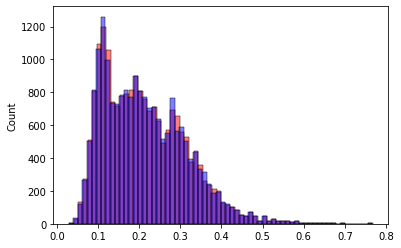

In [17]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df2[df2.exp_group == 1].likes.sum()/df2[df2.exp_group == 1].views.sum()
global_ctr_2 = df2[df2.exp_group == 2].likes.sum()/df2[df2.exp_group == 2].views.sum()

group1 = df2[df2.exp_group == 1].ctr.copy()

group2 = df2[df2.exp_group == 2].ctr.copy()

group1['smothed_ctr'] = df2.apply(
lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
sns.histplot(group1.smothed_ctr, color = 'r', alpha = 0.5,
kde = False)

group2['smothed_ctr'] = df2.apply(
lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
sns.histplot(group2.smothed_ctr, color = 'b', alpha = 0.5,
kde = False)

### Пуасоновский бутстреп показывает явную статистическую разницу в пользу контроля

<AxesSubplot:ylabel='Count'>

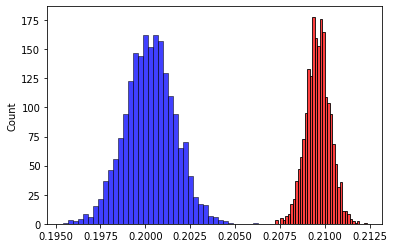

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

likes1 = df2[df2.exp_group == 1].likes.to_numpy()
views1 = df2[df2.exp_group == 1].views.to_numpy()
likes2 = df2[df2.exp_group == 2].likes.to_numpy()
views2 = df2[df2.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1, color = 'r')
sns.histplot(ctr2, color = 'b')

### Бакетное преобразование

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

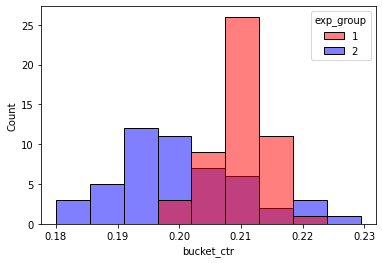

In [19]:
q = """
SELECT exp_group
     , bucket
     , sum(likes)/sum(views) as bucket_ctr
     , quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group
           , xxHash64(user_id)%50 as bucket
           , user_id
           , sum(action = 'like') as likes
           , sum(action = 'view') as views
           , likes/views as ctr
      FROM {db}.feed_actions
      WHERE toDate(time) between '2025-02-21' and '2025-02-27'
      and exp_group in (1,2)
      GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df3 = ph.read_clickhouse(q, connection=connection)

sns.histplot(data = df3,
x='bucket_ctr',
hue = 'exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

In [20]:
tt_bucket = stats.ttest_ind(df3[df3.exp_group == 1].bucket_ctr,
                            df3[df3.exp_group == 2].bucket_ctr,
                            alternative = 'two-sided')

if tt_bucket[1] >= 0.05: print('Распределения одинаковы, P-value =', tt_bucket[1])
else: print('Различия статистически значимы, P-value =', tt_bucket[1])

Различия статистически значимы, P-value = 1.8366051119101797e-07


In [21]:
mw_bucket = stats.mannwhitneyu(df3[df3.exp_group == 1].bucket_ctr,
                               df3[df3.exp_group == 2].bucket_ctr,
                               alternative = 'two-sided')

if mw_bucket[1] >= 0.05: print('Распределения одинаковы, P-value =', mw_bucket[1])
else: print('Различия статистически значимы, P-value =', mw_bucket[1])

Различия статистически значимы, P-value = 2.6576427804010095e-07


### Новую систему рекомедаций вводить не стоит, она увеличивает лишь CTR конкретных групп, при этом уменьшает количество лайков большинства. Применив другие способы выявления статистической значимости мы ещё и убедились что контрольная группа показывает себя лучше.

## Пробуем увеличить чувствительность теста через линеаризацию

In [113]:
q = """
SELECT exp_group
     , user_id
     , sum(action = 'like') as likes
     , sum(action = 'view') as views
     , likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-21' and '2025-02-27'
    AND exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df4 = ph.read_clickhouse(q, connection=connection)

In [117]:
CTR_control_0 = df4[df4['exp_group'] == 0]['likes'].sum() / df4[df4['exp_group'] == 0]['views'].sum()
CTR_control_1 = df4[df4['exp_group'] == 1]['likes'].sum() / df4[df4['exp_group'] == 1]['views'].sum()

### Линеаризованные лайки

linearized_likes_0 = df4[df4['exp_group'] == 0]['likes'] - CTR_control_0 * df4[df4['exp_group'] == 0]['views']
linearized_likes_1 = df4[df4['exp_group'] == 1]['likes'] - CTR_control_1 * df4[df4['exp_group'] == 1]['views']
linearized_likes_3 = df4[df4['exp_group'] == 3]['likes'] - CTR_control_0 * df4[df4['exp_group'] == 3]['views']
linearized_likes_2 = df4[df4['exp_group'] == 2]['likes'] - CTR_control_1 * df4[df4['exp_group'] == 2]['views']

### Т-Тесты

just_ctr_0n3 = stats.ttest_ind(df4[df4['exp_group'] == 0].ctr, df4[df4['exp_group'] == 3].ctr)
just_ctr_1n2 = stats.ttest_ind(df4[df4['exp_group'] == 1].ctr, df4[df4['exp_group'] == 2].ctr)

if just_ctr_0n3[1] >= 0.05: print('Распределения одинаковы, пользовательское P-value группы 0 и 3 =', just_ctr_0n3[1])
else: print('Различия статистически значимы, пользовательское P-value группы 0 и 3 =', just_ctr_0n3[1])

if just_ctr_1n2[1] >= 0.05: print('Распределения одинаковы, пользовательское P-value группы 1 и 2 =', just_ctr_1n2[1])
else: print('Различия статистически значимы, пользовательское P-value группы 1 и 2 =', just_ctr_1n2[1])

print() # отступ

linez_0n3 = stats.ttest_ind(linearized_likes_0, linearized_likes_3)

if linez_0n3[1] >= 0.05: print('Распределения одинаковы, линеаризованное P-value группы 0 и 3 =', linez_0n3[1])
else: print('Различия статистически значимы, линеаризованное P-value группы 0 и 3 =', linez_0n3[1])

linez_1n2 = stats.ttest_ind(linearized_likes_1, linearized_likes_2)

if linez_1n2[1] >= 0.05: print('Распределения одинаковы, линеаризованное P-value группы 1 и 2 =', linez_1n2[1])
else: print('Различия статистически значимы, линеаризованное P-value группы 1 и 2 =', linez_1n2[1])

Различия статистически значимы, пользовательское P-value группы 0 и 3 = 6.360547724658604e-44
Распределения одинаковы, пользовательское P-value группы 1 и 2 = 0.6843098628062774

Различия статистически значимы, линеаризованное P-value группы 0 и 3 = 1.4740034890835593e-58
Различия статистически значимы, линеаризованное P-value группы 1 и 2 = 2.5335696161435772e-09


### Линеаризация увеличила чувствительность нашего t-теста. Считается она быстро, и при этом фактически проверяет ту же гипотезу, что и пуассоновский бутстрап. Резюмируя, этот метод отлично подходит для анализа метрик-отношений
